In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import * 
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

from kerashypetune import KerasGridSearch

In [2]:
### READ DATA ###

df = pd.read_csv('Punta_Salute_2009.csv', sep=';')
df = df.dropna()

print(df.shape)
df.head()

(8760, 3)


,Data,Ora solare,Livello P.Salute Canal Grande (cm)
0,01-gen-09,01:00,34.0
1,01-gen-09,02:00,37.0
2,01-gen-09,03:00,36.0
3,01-gen-09,04:00,29.0
4,01-gen-09,05:00,20.0


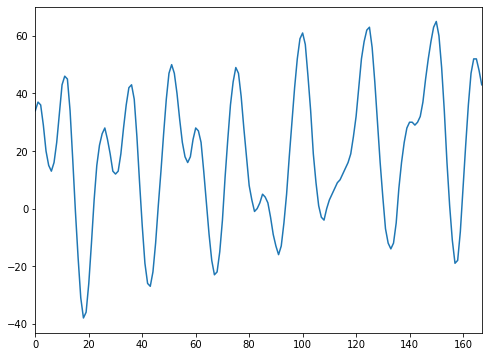

In [3]:
### PLOT WEEKLY TREND ###

df[:7*24]['Livello P.Salute Canal Grande (cm)'].plot(y='Livello P.Salute Canal Grande (cm)', x='Ora solare', figsize=(8,6))

In [4]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(1, self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(1, 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [5]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 24

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [6]:
### DEFINE MODEL STRUCTURES ###

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [7]:
### PREPARE DATA TO FEED MODELS ###

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['Livello P.Salute Canal Grande (cm)']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [8]:
### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6132, 24, 1) (6132, 1)
(2604, 24, 1) (2604, 1)


In [9]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

param_grid = {
    'unit': [64,32],
    't2v_dim': [128,64],
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'epochs': 200,
    'batch_size': [512,1024]
}

In [10]:
### FIT T2V + LSTM ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: T2V_NN(param=x, dim=sequence_length)

kgs_t2v = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_t2v.set_seed(set_seed_TF2, seed=33)
kgs_t2v.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)


32 trials detected for ('unit', 't2v_dim', 'lr', 'act', 'epochs', 'batch_size')

***** (1/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 395.49994 at epoch 2

***** (2/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 7.12334 at epoch 62

***** (3/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 758.4574 at epoch 200

***** (4/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 4.72982 at epoch 32

***** (5/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 5.00203 at epoch 28

***** (6/32) *****
Search({'unit': 64, 't2v_dim': 128, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 4.733 at epoch 69

***** (7/32) *****
Search({'unit': 64, 't2v_di

In [11]:
pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_t2v)

1.9867963822395434

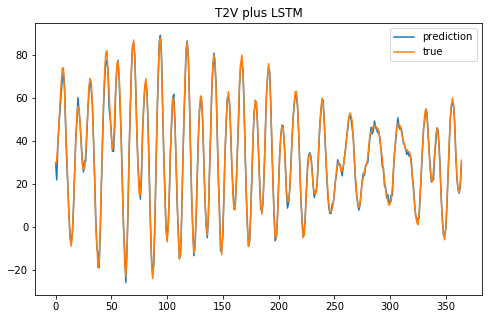

In [12]:
### VISUALIZE TEST PREDICTIONS ###

plt.figure(figsize=(8,5))

plt.plot(pred_t2v[:365], label='prediction')
plt.plot(y_test.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

In [13]:
### FIT SIMPLE LSTM ###

del param_grid['t2v_dim']

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: NN(param=x, dim=sequence_length)

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.set_seed(set_seed_TF2, seed=33)
kgs.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)


16 trials detected for ('unit', 'lr', 'act', 'epochs', 'batch_size')

***** (1/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 567.87518 at epoch 7

***** (2/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 4.17391 at epoch 51

***** (3/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 49.53372 at epoch 21

***** (4/16) *****
Search({'unit': 64, 'lr': 0.01, 'act': 'relu', 'epochs': 200, 'batch_size': 1024})
SCORE: 4.12449 at epoch 41

***** (5/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 512})
SCORE: 105.60397 at epoch 5

***** (6/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'elu', 'epochs': 200, 'batch_size': 1024})
SCORE: 4.91124 at epoch 72

***** (7/16) *****
Search({'unit': 64, 'lr': 0.001, 'act': 'relu', 'epochs': 200, 'batch_size': 512})
SCORE: 8.16518 at epoch 40

***** (8/16) *****
Se

In [14]:
pred_nn = kgs.best_model.predict(X_test).ravel()
mean_absolute_error(y_test.ravel(), pred_nn)

2.0274327399120446

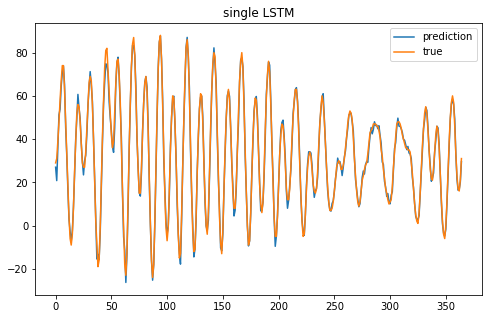

In [15]:
### VISUALIZE TEST PREDICTIONS ###

plt.figure(figsize=(8,5))

plt.plot(pred_nn[:365], label='prediction')
plt.plot(y_test.ravel()[:365], label='true')
plt.title('single LSTM'); plt.legend()